# Reddit NLP Classifier

## Data Modeling & Evaluation (4/4)

## Contents
- [Modeling](#Modeling)
- [Evaluation](#Evaluation)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

## Modeling

- Four different models were developed and tested using Logistic Regression and Multinomial NB, with the use of Count Vectorizer and TF-IDF Vectorizer. 
- The data was split into training and testing sets using an 80/20 split ratio. 
- Grid-search Cross-validation with 5-folds was used to identify the best hyperparameters for each model. 
- The performance of each model was evaluated using a range of metrics, including train and test accuracy as well as ROC AUC score. Also, a confusion matrix was created to visually represent the performance of the models and review classification metrics such as precision and recall (sensitivity). 

### All libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score


In [2]:
# Change to display the max number of rows and columns
# Reference: https://kakakakakku.hatenablog.com/entry/2021/04/19/090229
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Data Import

In [3]:
# Read in the data 
df = pd.read_csv('../data/subreddits_preprocessing_eda.csv')

# Review
df.head()

,subreddit,body,body_preprocessed,word_count,subreddit_label
0,malefashionadvice,Definitely agree there’s personality there. Se...,definitely agree there s personality there see...,21,1
1,malefashionadvice,You're looking for high fashion designers bro....,you re looking for high fashion designer bro t...,60,1
2,malefashionadvice,"Yeah, I’d add photos if I knew exactly what I ...",yeah i d add photo if i knew exactly what i wa...,69,1
3,malefashionadvice,[cool cardigan](https://i.pinimg.com/736x/80/6...,cool excited for this to come,6,1
4,malefashionadvice,"Workout clothes, sleepwear, and socks.\n\nI kn...",workout clothes sleepwear and sock i know it s...,39,1


In [4]:
# Check the number of missing values 
df.isnull().sum()

subreddit             0
body                  0
body_preprocessed    42
word_count            0
subreddit_label       0
dtype: int64

In [5]:
# Fill Nan values with ''
df = df.fillna('')

# Review
df.isnull().sum()

subreddit            0
body                 0
body_preprocessed    0
word_count           0
subreddit_label      0
dtype: int64

### Baseline Model 

Baseline is used as a benchmark to the classification methods. The models should achieve a better score than this baseline of 0.5

In [6]:
# Calculate baseline 
df['subreddit_label'].value_counts(normalize = True)

1    0.5
0    0.5
Name: subreddit_label, dtype: float64

In [7]:
# Create 'Baseline'
baseline = 1 - df['subreddit_label'].mean()
baseline

0.5

### Train/Test Split

In [8]:
# Create matrix (X) and vector (y)
X = df['body_preprocessed']
y = df['subreddit_label']


In [9]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=123,
                                                    stratify=y,
                                                    test_size=0.2)

### Data Modeling

#### (1.1) Count Vectorizer, Multinomial NB

In [10]:
# Use Pipelines and Grid-search Cross-validation (GridsearchCV) to optimize the model
# Reference: GA's 5.05 NLP II Lesson
pipe_cvec_mn = Pipeline([
    ('cvec', CountVectorizer()),
    ('mn', MultinomialNB())
])

# Load Pipeline object into GridSearchCV
#pipe.get_params()

# Search over the following values of hyperparameters:
pipe_cvec_mn_params = {
    'cvec__max_features': [None, 1_000, 2_000, 3_000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [1.0, 0.9],
    'cvec__ngram_range': [(1, 1), (1, 2)], 
    'mn__alpha': [1.0, 0.1, 0.01]
}

# Instantiate GridSearchCV.
gs_cvec_mn = GridSearchCV(pipe_cvec_mn, 
                          param_grid = pipe_cvec_mn_params, 
                          cv = 5) # 5-fold cross-validation

# Fit GridSearch to training data.
gs_cvec_mn.fit(X_train, y_train)

# The model performance
print(f"CountVectorizer & Multinomial NB")
print(f"----------")
print(f"train accuracy: {round(gs_cvec_mn.score(X_train, y_train), 3)}")
print(f"test accuracy: {round(gs_cvec_mn.score(X_test, y_test), 3)}")
print(f"baseline: {baseline}")
print(f"best score: {round(gs_cvec_mn.best_score_, 3)}")
print(f"best performing features: {gs_cvec_mn.best_params_}")


CountVectorizer & Multinomial NB
----------
train accuracy: 0.933
test accuracy: 0.81
baseline: 0.5
best score: 0.789
best performing features: {'cvec__max_df': 1.0, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'mn__alpha': 0.1}


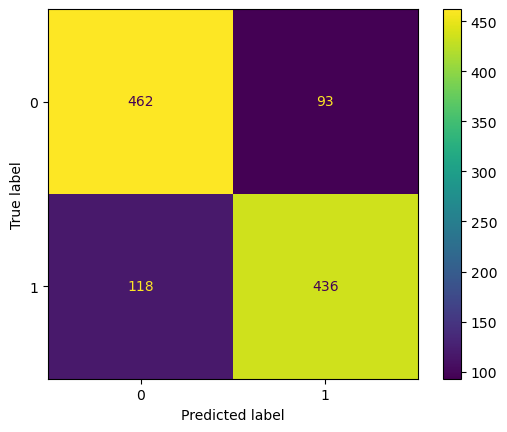

In [11]:
# Generate preds 
preds_cvec_mn = gs_cvec_mn.predict(X_test)

# Create confusion matrix
cm_cvec_mn = confusion_matrix(y_test, preds_cvec_mn)

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, preds_cvec_mn, display_labels=gs_cvec_mn.classes_);

In [12]:
# Calculate precision
precision_cvec_mn = precision_score(y_test, preds_cvec_mn, average='binary')

# Calculate F1-score
f1_cvec_mn = f1_score(y_test, preds_cvec_mn, average='binary')

# Calculate sensitivity/recall
recall_cvec_mn = recall_score(y_test, preds_cvec_mn, average='binary')

# Print the metrics
print(f"CountVectorizer & Multinomial NB")
print(f"----------")
print(f'Precision: {round(precision_cvec_mn, 3)}')
print(f'Recall: {round(recall_cvec_mn, 3)}')
print(f'F1-Score: {round(f1_cvec_mn, 3)}')

CountVectorizer & Multinomial NB
----------
Precision: 0.824
Recall: 0.787
F1-Score: 0.805


In [13]:
# ROC AUC = Receiver Operating Characteristic Area Under Curve
roc_cvec_mn = roc_auc_score(y_test, gs_cvec_mn.predict_proba(X_test)[:,1])

print(f"CountVectorizer & Multinomial NB")
print(f"----------")
print(f"ROC AUC: {round(roc_cvec_mn, 3)}")

CountVectorizer & Multinomial NB
----------
ROC AUC: 0.901


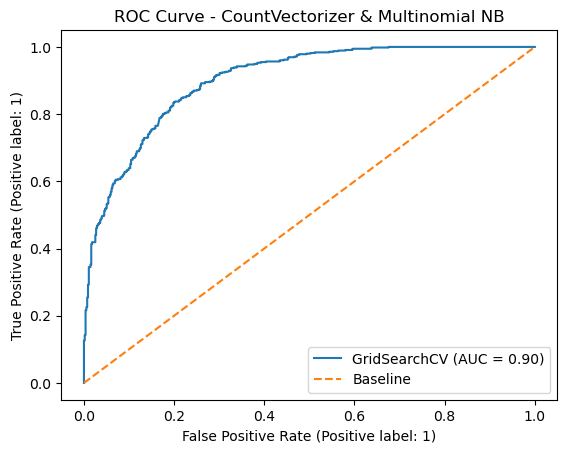

In [14]:
# Reference: GA 405 Classification Metrics II Lesson
# Plot
RocCurveDisplay.from_estimator(gs_cvec_mn, X_test, y_test)
plt.plot([0,1], [0,1],
        label = 'Baseline',
        linestyle = '--')
plt.title('ROC Curve - CountVectorizer & Multinomial NB')
plt.legend();

#### (1.2) Count Vectorizer, Logistic Regression

In [15]:
# Use Pipelines and Grid-search Cross-validation (GridsearchCV) to optimize the model
# Reference: GA's 5.05 NLP II Lesson
pipe_cvec_log = Pipeline([
    ('cvec', CountVectorizer()),
    ('log', LogisticRegression())
])

# Load Pipeline object into GridSearchCV
#pipe.get_params()

# Search over the following values of hyperparameters:
# Reference: https://towardsdatascience.com/tuning-the-hyperparameters-of-your-machine-learning-model-using-gridsearchcv-7fc2bb76ff27
# Reference: https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati)
pipe_cvec_log_params = {
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__max_features': [None, 1_000, 2_000, 3_000],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [1.0, 0.9],
    'log__solver': ['liblinear'], 
    'log__max_iter': [5_000],  
    'log__penalty': ['l1', 'l2'], 
    'log__C': [1, 0.1, 0.01],
}
    
# Instantiate GridSearchCV.
gs_cvec_log = GridSearchCV(pipe_cvec_log, 
                           param_grid = pipe_cvec_log_params, 
                           cv = 5)

# Fit GridSearch to training data.
gs_cvec_log.fit(X_train, y_train)

# Check the accuracy 
print(f"CountVectorizer & Logistic Regression")
print(f"----------")
print(f"train accuracy: {round(gs_cvec_log.score(X_train, y_train), 3)}")
print(f"test accuracy: {round(gs_cvec_log.score(X_test, y_test), 3)}")
print(f"baseline: {baseline}")
print(f"best score: {round(gs_cvec_log.best_score_, 3)}")
print(f"best performing features: {gs_cvec_log.best_params_}")



CountVectorizer & Logistic Regression
----------
train accuracy: 0.963
test accuracy: 0.787
baseline: 0.5
best score: 0.78
best performing features: {'cvec__max_df': 1.0, 'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 1), 'log__C': 1, 'log__max_iter': 5000, 'log__penalty': 'l2', 'log__solver': 'liblinear'}


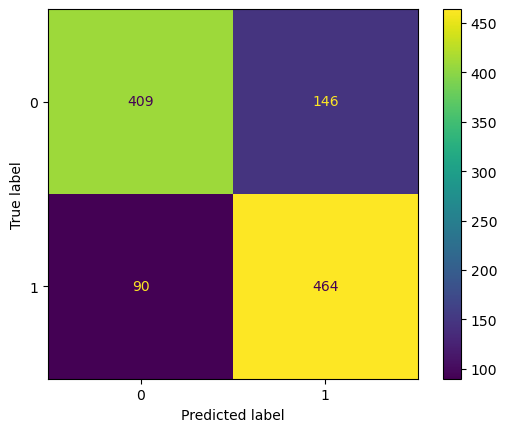

In [16]:
# Generate preds 
preds_cvec_log = gs_cvec_log.predict(X_test)

# Create confusion matrix
cm_cvec_log = confusion_matrix(y_test, preds_cvec_log)

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, preds_cvec_log, display_labels=gs_cvec_log.classes_);

In [17]:
# Calculate precision
precision_cvec_log = precision_score(y_test, preds_cvec_log, average='binary')

# Calculate F1-score
f1_cvec_log = f1_score(y_test, preds_cvec_log, average='binary')

# Calculate sensitivity/recall
recall_cvec_log = recall_score(y_test, preds_cvec_log, average='binary')

# Print the metrics
print(f"CountVectorizer & Logistic Regression")
print(f"----------")
print(f'Precision: {round(precision_cvec_log, 3)}')
print(f'Recall: {round(recall_cvec_log, 3)}')
print(f'F1-Score: {round(f1_cvec_log, 3)}')

CountVectorizer & Logistic Regression
----------
Precision: 0.761
Recall: 0.838
F1-Score: 0.797


In [18]:
# ROC AUC = Receiver Operating Characteristic Area Under Curve
roc_cvec_log = roc_auc_score(y_test, gs_cvec_log.predict_proba(X_test)[:,1])

print(f"CountVectorizer & Logistic Regression")
print(f"----------")
print(f"ROC AUC: {round(roc_cvec_log, 3)}")

CountVectorizer & Logistic Regression
----------
ROC AUC: 0.872


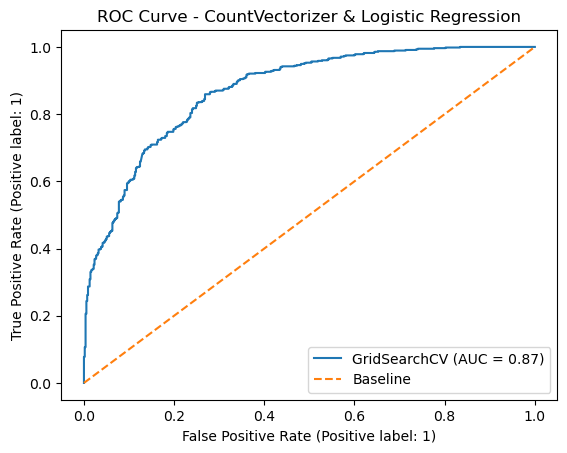

In [19]:
# Reference: GA 405 Classification Metrics II Lesson
# Plot
RocCurveDisplay.from_estimator(gs_cvec_log, X_test, y_test)
plt.plot([0,1], [0,1],
        label = 'Baseline',
        linestyle = '--')
plt.title('ROC Curve - CountVectorizer & Logistic Regression')
plt.legend();

Here are the results of train/test accuracy and specificy from two models using Count Vectorizer. 

|Transformer Type|Model Type|Train Accuracy|Test Accuracy|Precision|Recall|F1-Score|AUC|
|--|--|--|--|--|--|--|--|
|Count Vectorizer|Multinomial NB|0.933|0.810|0.824|0.787|0.805|0.901|
|Count Vectorizer|Logistic Regression|0.963|0.787|0.761|0.838|0.797|0.872|

### (2) Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer 

#### (2.1) TF-IDF Vectorizer, Multinomial NB

In [20]:
# Use Pipelines and Grid-search Cross-validation (GridsearchCV) to optimize the model
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# Reference: GA's 5.05 NLP II Lesson
pipe_tvec_mn = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mn', MultinomialNB())
])

# Load Pipeline object into GridSearchCV
#pipe.get_params()

# Search over the following values of hyperparameters:
pipe_tvec_mn_params = {
    'tvec__max_features': [None, 1_000, 2_000, 3_000],
    'tvec__min_df': [1, 2, 3],
    'tvec__max_df': [1.0, .9],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'mn__alpha': [1.0, 0.1, 0.01]
}

# Instantiate GridSearchCV.
gs_tvec_mn = GridSearchCV(pipe_tvec_mn, 
                          param_grid = pipe_tvec_mn_params, 
                          cv = 5)

# Fit GridSearch to training data.
gs_tvec_mn.fit(X_train, y_train)

# Check the accuracy 
print(f"TfidfVectorizer & Multinomial NB")
print(f"----------")
print(f"train accuracy: {round(gs_tvec_mn.score(X_train, y_train), 3)}")
print(f"test accuracy: {round(gs_tvec_mn.score(X_test, y_test), 3)}")
print(f"baseline: {baseline}")
print(f"best score: {round(gs_tvec_mn.best_score_, 3)}")
print(f"best performing features: {gs_tvec_mn.best_params_}")


TfidfVectorizer & Multinomial NB
----------
train accuracy: 0.952
test accuracy: 0.817
baseline: 0.5
best score: 0.791
best performing features: {'mn__alpha': 0.1, 'tvec__max_df': 1.0, 'tvec__max_features': None, 'tvec__min_df': 1, 'tvec__ngram_range': (1, 1)}


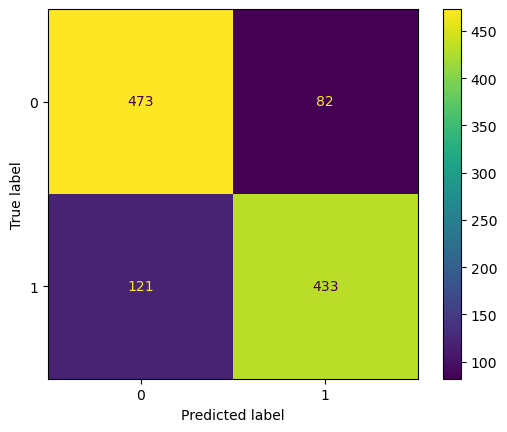

In [21]:
# Generate preds 
preds_tvec_mn = gs_tvec_mn.predict(X_test)

# Create confusion matrix
cm_tvec_mn = confusion_matrix(y_test, preds_tvec_mn)

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, preds_tvec_mn, display_labels=gs_tvec_mn.classes_);

In [22]:
# Calculate precision
precision_tvec_mn = precision_score(y_test, preds_tvec_mn, average='binary')

# Calculate F1-score
f1_tvec_mn = f1_score(y_test, preds_tvec_mn, average='binary')

# Calculate sensitivity/recall
recall_tvec_mn = recall_score(y_test, preds_tvec_mn, average='binary')

# Print the metrics
print(f"TfidfVectorizer & Multinomial NB")
print(f"----------")
print(f'Precision: {round(precision_tvec_mn, 3)}')
print(f'Recall: {round(recall_tvec_mn, 3)}')
print(f'F1-Score: {round(f1_tvec_mn, 3)}')

TfidfVectorizer & Multinomial NB
----------
Precision: 0.841
Recall: 0.782
F1-Score: 0.81


In [23]:
# ROC AUC = Receiver Operating Characteristic Area Under Curve
roc_tvec_mn = roc_auc_score(y_test, gs_tvec_mn.predict_proba(X_test)[:,1])

print(f"TfidfVectorizer & Multinomial NB")
print(f"----------")
print(f"ROC AUC: {round(roc_tvec_mn, 3)}")

TfidfVectorizer & Multinomial NB
----------
ROC AUC: 0.906


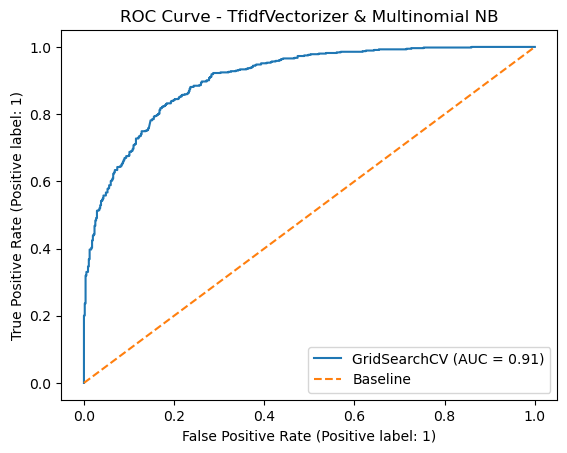

In [24]:
# Reference: GA 405 Classification Metrics II Lesson
# Plot
RocCurveDisplay.from_estimator(gs_tvec_mn, X_test, y_test)
plt.plot([0,1], [0,1],
        label = 'Baseline',
        linestyle = '--')
plt.title('ROC Curve - TfidfVectorizer & Multinomial NB')
plt.legend();

#### (2.2) TF-IDF Vectorizer, Logistic Regression

In [25]:
# Use Pipelines and Grid-search Cross-validation (GridsearchCV) to optimize the model
# Reference: GA's 5.05 NLP II Lesson
pipe_tvec_log = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('log', LogisticRegression())
])

# Load Pipeline object into GridSearchCV
#pipe.get_params()

# Search over the following values of hyperparameters:
# Reference: https://towardsdatascience.com/tuning-the-hyperparameters-of-your-machine-learning-model-using-gridsearchcv-7fc2bb76ff27
# Reference: https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati
pipe_tvec_log_params = {
    'tvec__ngram_range': [(1, 1), (1,2)],
    'tvec__max_features': [None, 1_000, 2_000, 3_000],
    'tvec__min_df': [1, 2, 3],
    'tvec__max_df': [1.0, 0.9],
    'log__solver': ['liblinear'], 
    'log__max_iter': [5_000],  
    'log__penalty': ['l1', 'l2'],   
    'log__C': [1, 0.1, 0.01],
}

# Instantiate GridSearchCV.
gs_tvec_log = GridSearchCV(pipe_tvec_log, 
                           param_grid = pipe_tvec_log_params, 
                           cv = 5)

# Fit GridSearch to training data.
gs_tvec_log.fit(X_train, y_train)

# Check the accuracy 
print(f"TfidfVectorizer & Logistic Regression")
print(f"----------")
print(f"train accuracy: {round(gs_tvec_log.score(X_train, y_train), 3)}")
print(f"test accuracy: {round(gs_tvec_log.score(X_test, y_test), 3)}")
print(f"baseline: {baseline}")
print(f"best score: {round(gs_tvec_log.best_score_, 3)}")
print(f"best performing features: {gs_tvec_log.best_params_}")


TfidfVectorizer & Logistic Regression
----------
train accuracy: 0.88
test accuracy: 0.795
baseline: 0.5
best score: 0.777
best performing features: {'log__C': 1, 'log__max_iter': 5000, 'log__penalty': 'l2', 'log__solver': 'liblinear', 'tvec__max_df': 1.0, 'tvec__max_features': None, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}


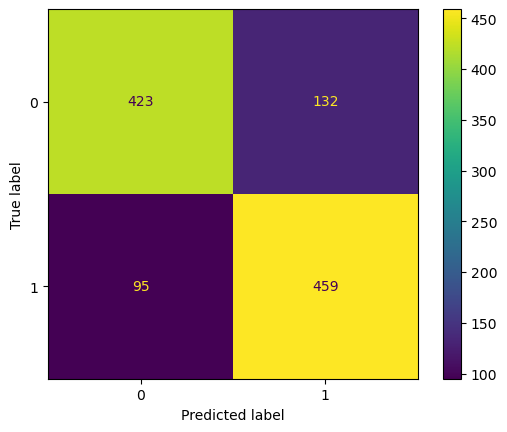

In [26]:
# Generate preds 
preds_tvec_log = gs_tvec_log.predict(X_test)

# Create confusion matrix
cm_tvec_log = confusion_matrix(y_test, preds_tvec_log)

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, preds_tvec_log, display_labels=gs_tvec_log.classes_);

In [27]:
# Calculate precision
precision_tvec_log = precision_score(y_test, preds_tvec_log, average='binary')

# Calculate F1-score
f1_tvec_log = f1_score(y_test, preds_tvec_log, average='binary')

# Calculate sensitivity/recall
recall_tvec_log = recall_score(y_test, preds_tvec_log, average='binary')

# Print the metrics
print(f"TfidfVectorizer & Logistic Regression")
print(f"----------")
print(f'Precision: {round(precision_tvec_log, 3)}')
print(f'Recall: {round(recall_tvec_log, 3)}')
print(f'F1-Score: {round(f1_tvec_log, 3)}')

TfidfVectorizer & Logistic Regression
----------
Precision: 0.777
Recall: 0.829
F1-Score: 0.802


In [28]:
# ROC AUC = Receiver Operating Characteristic Area Under Curve
roc_tvec_log = roc_auc_score(y_test, gs_tvec_log.predict_proba(X_test)[:,1])

print(f"TfidfVectorizer & Logistic Regression")
print(f"----------")
print(f"ROC AUC: {round(roc_tvec_log, 3)}")

TfidfVectorizer & Logistic Regression
----------
ROC AUC: 0.87


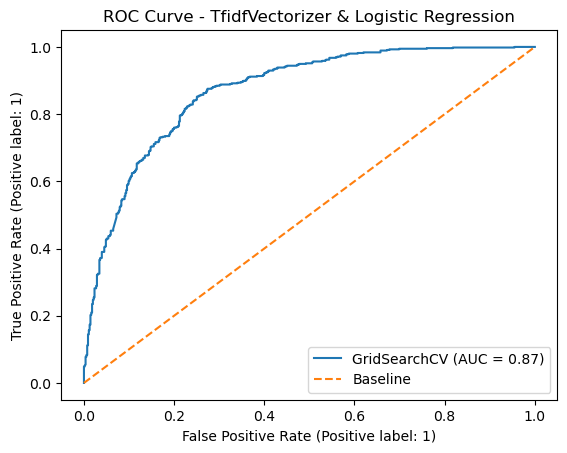

In [29]:
# Reference: GA 405 Classification Metrics II Lesson
# Plot
RocCurveDisplay.from_estimator(gs_tvec_log, X_test, y_test)
plt.plot([0,1], [0,1],
        label = 'Baseline',
        linestyle = '--')
plt.title('ROC Curve - TfidfVectorizer & Logistic Regression')
plt.legend();

Here are the results of train/test accuracy and specificy from two models using TFID Vectorizer.

|Transformer Type|Model Type|Train Accuracy|Test Accuracy|Precision|Recall|F1-Score|AUC|
|--|--|--|--|--|--|--|--|
|TF-IDF Vectorizer|Multinomial NB|0.952|0.817|0.841|0.782|0.810|0.906
|TF-IDF Vectorizer|Logistic Regression|0.880|0.795|0.777|0.829|0.802|0.870|

## Evaluation

Here are scores and metrics to evaluate different classifier models and forms of vectorization.

|Transformer Type|Model Type|Train Accuracy|Test Accuracy|Precision|Recall|F1-Score|AUC|
|--|--|--|--|--|--|--|--|
|Count Vectorizer|Multinomial NB|0.933|0.810|0.824|0.787|0.805|0.901|
|Count Vectorizer|Logistic Regression|0.963|0.787|0.761|0.838|0.797|0.872|
|TF-IDF Vectorizer|Multinomial NB|0.952|0.817|0.841|0.782|0.810|0.906
|TF-IDF Vectorizer|Logistic Regression|0.880|0.795|0.777|0.829|0.802|0.870|

## Conclusion and Recommendations

Based on the evaluation metrics provided, both the TF-IDF Vectorizer with Multinomial Naive Bayes model and the Count Vectorizer with Multinomial Naive Bayes model achieve good accuracy in classifying posts from the two subreddits.

However, the TF-IDF Vectorizer with Multinomial Naive Bayes model achieves a slightly higher test accuracy of 0.817, indicating that this model may be better at accurately classifying posts from the two subreddits. On the other hand, the Count Vectorizer with Multinomial Naive Bayes model achieved higher recall values, which indicates that this model may be better at identifying all the posts from a particular subreddit.

The choice of vectorization technique depends on the specific needs and goals of the project. If the priority is to accurately classify posts from the two subreddits, then the TF-IDF Vectorizer with Multinomial Naive Bayes model may be the better choice. However, if the priority is to ensure that all posts from a particular subreddit are identified, then the Count Vectorizer with Multinomial Naive Bayes model may be more suitable.

In any case, it is recommended to conduct further analysis and fine-tuning of both models to improve the precision and recall values, particularly for the subreddit with lower recall. This could involve exploring different feature selection techniques or adjusting the hyperparameters of the models.